{% include toc title="On This Page" icon="file-text" %}

<div class='notice--success' markdown="1">

## <i class="fa fa-graduation-cap" aria-hidden="true"></i> Learning Objectives

* Join spatial attributes from one shapefile to another using **geopandas** in **Python**.
* Calculate line segment length **geopandas** in **Python**.

</div>

Get started by loading your libraries and setting your working directory. 

In [10]:
# Import libraries
import os
import matplotlib.pyplot as plt
import matplotlib.lines as mlines
from matplotlib.colors import ListedColormap
import numpy as np
import pandas as pd
from shapely.geometry import box
import geopandas as gpd
import earthpy as et

# Set working dir & get data
data = et.data.get_data('spatial-vector-lidar')
os.chdir(os.path.join(et.io.HOME, 'earth-analytics'))

In [11]:
# Import data
data_path = os.path.join("data/spatial-vector-lidar")

country_bound_us = gpd.read_file(os.path.join(data_path, "usa", 
                                              "usa-boundary-dissolved.shp"))
                                 
state_bound_us = gpd.read_file(os.path.join(data_path, "usa", 
                                            "usa-states-census-2014.shp"))
                               
pop_places = gpd.read_file(os.path.join(data_path, "global", 
                                        "ne_110m_populated_places_simple", 
                                        "ne_110m_populated_places_simple.shp"))
                                        
ne_roads = gpd.read_file(os.path.join(data_path, "global", 
                                      "ne_10m_roads", "ne_10m_roads.shp"))

Next dissolve the state data by region like you did in the previous lesson. 

In [12]:
# Simplify the country boundary just a little bit to make this run faster
country_bound_us_simp = country_bound_us.simplify(.2, preserve_topology=True)

# Clip the roads to the US boundary - this will take about a minute to execute
roads_cl = gpd.clip(ne_roads, country_bound_us_simp)
roads_cl.crs = ne_roads.crs

# Dissolve states by region
regions_agg = state_bound_us.dissolve(by="region")

/home/nathan/miniconda3/envs/earth-analytics-python/lib/python3.7/site-packages/geopandas/geoseries.py:358: UserWarning: GeoSeries.notna() previously returned False for both missing (None) and empty geometries. Now, it only returns False for missing values. Since the calling GeoSeries contains empty geometries, the result has changed compared to previous versions of GeoPandas.
Given a GeoSeries 's', you can use '~s.is_empty & s.notna()' to get back the old behaviour.

To further ignore this warning, you can do: 
import warnings; warnings.filterwarnings('ignore', 'GeoSeries.notna', UserWarning)
  return self.notna()


## Spatial Joins in Python

Just like you might do in ArcMap or QGIS you can perform spatial joins in Python too. A spatial join is when you append the attributes of one layer to another based upon its spatial relationship.

So - for example if you have a roads layer for the United States, and you want to apply the "region" attribute to every road that is spatially in a particular region, you would use a spatial join. To apply a join you can use the `geopandas.sjoin()` function as following:

`.sjoin(layer-to-add-region-to, region-polygon-layer)`

### Sjoin Arguments:

The `op` argument specifies the type of join that will be applied

* `intersects`: Returns True if the boundary and interior of the object intersect in any way with those of the other.
* `within`: Returns True if the object’s boundary and interior intersect only with the interior of the other (not its boundary or exterior).
* `contains`: Returns True if the object’s interior contains the boundary and interior of the other object and their boundaries do not touch at all.

<a href ="https://shapely.readthedocs.io/en/stable/manual.html?highlight=binary%20predicates#binary-predicates" target = "_blank">You can read more about each type here.</a>
 
How allows the following options: (this is taken directly from the <a href = "https://github.com/geopandas/geopandas/blob/master/geopandas/tools/sjoin.py#L18" target = "_blank">geopandas code on github!</a>

* 'left': use keys from left_df; retain only left_df geometry column
* 'right': use keys from right_df; retain only right_df geometry column
* 'inner': use intersection of keys from both dfs; retain only
          left_df geometry column 

In [13]:
# Roads within region
roads_region = gpd.sjoin(roads_cl, 
                         regions_agg, 
                         how="inner", 
                         op='intersects')

# Notice once you have joins the data - you have attributes 
# from the regions_object (i.e. the region) attached to each road feature
roads_region[["featurecla", "index_right", "ALAND"]].head()

,featurecla,index_right,ALAND
1,Road,Midwest,143794747023
3,Road,Midwest,143794747023
6,Road,Midwest,143794747023
7,Road,Midwest,143794747023
54,Road,Midwest,143794747023


Plot the data.

In [14]:
# Reproject to Albers for plotting
country_albers = country_bound_us.to_crs({'init': 'epsg:5070'})
roads_albers = roads_region.to_crs({'init': 'epsg:5070'})

/home/nathan/miniconda3/envs/earth-analytics-python/lib/python3.7/site-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))
/home/nathan/miniconda3/envs/earth-analytics-python/lib/python3.7/site-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


In [15]:
# leg1 = ax.legend(lines, [lines.get_label() for lines in lines], loc=(1.1, .1), 
#                   prop={'size': 16},
#                    frameon=False, 
#                   title='Plot Type')

#roads = [mlines.Line2D([0], [0], color=c, linewidth = width) for c, width in zip(road_colors, line_widths)]
#road_names = np.unique(us_roads_only['type'])

# First, create a dictionary with the attributes of each legend item
road_attrs = {'Beltway': ['black', 2],
              'Secondary Highway': ['grey', .5],
              'Road': ['grey', .5],
              'Bypass': ['grey', .5],
              'Ferry Route': ['grey', .5],
              'Major Highway': ['black', 1]}


# road_colors = ['black', 'grey', 'grey', 'black', 'grey', 'grey' ]
# line_widths = [1, .5, .5, 1, .5, .5]

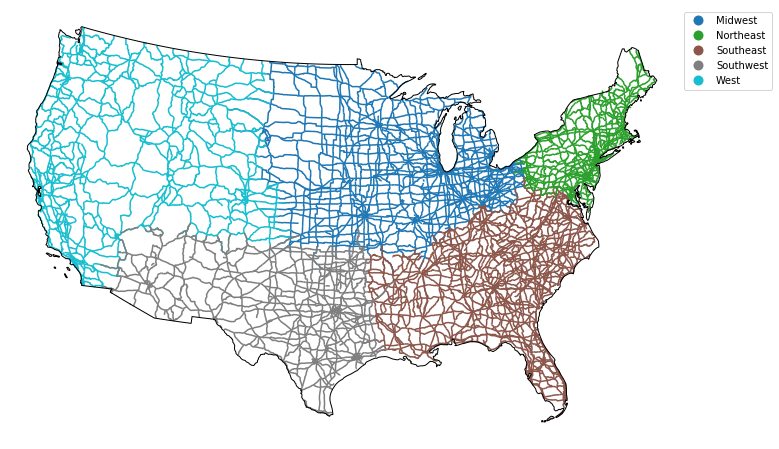

In [16]:
# Plot the data
fig, ax = plt.subplots(figsize=(12, 8))

country_albers.plot(alpha=1,
                    facecolor="none",
                    edgecolor="black",
                    zorder=10,
                    ax=ax)

roads_albers.plot(column='index_right',
                  ax=ax,
                  legend=True)

# Adjust legend location
leg = ax.get_legend()
leg.set_bbox_to_anchor((1.15,1))

ax.set_axis_off()
plt.axis('equal')
plt.show()

If you want to customize your legend even further, you can once again use loops to do so.


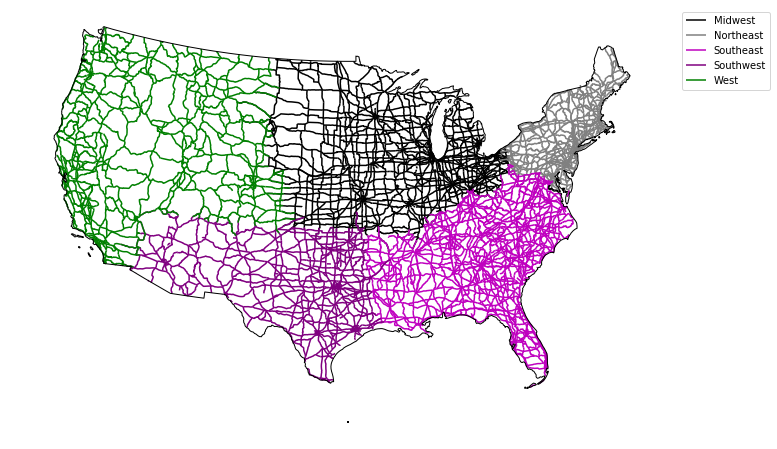

In [17]:
# First, create a dictionary with the attributes of each legend item
road_attrs = {'Midwest': ['black'],
              'Northeast': ['grey'],
              'Southeast': ['m'],
              'Southwest': ['purple'],
              'West': ['green']}

# Plot the data
fig, ax = plt.subplots(figsize=(12, 8))

regions_agg.plot(edgecolor="black",
                 ax=ax)
country_albers.plot(alpha=1,
                    facecolor="none",
                    edgecolor="black",
                    zorder=10,
                    ax=ax)

for ctype, data in roads_albers.groupby('index_right'):
    data.plot(color=road_attrs[ctype][0],
              label=ctype,
              ax=ax)
    
# This approach works to place the legend when you have defined labels
plt.legend(bbox_to_anchor=(1.0, 1), loc=2)
ax.set_axis_off()
plt.axis('equal')
plt.show()

## Calculate Line Segment Length

In [18]:
# Turn off scientific notation
pd.options.display.float_format = '{:.4f}'.format

# Calculate the total length of road 
road_albers_length = roads_albers[['index_right', 'length_km']]

# Sum existing columns
roads_albers.groupby('index_right').sum()

roads_albers['rdlength'] = roads_albers.length
sub = roads_albers[['rdlength', 'index_right']].groupby('index_right').sum()
sub

,rdlength
index_right,
Midwest,86575018.7717
Northeast,33786036.9011
Southeast,84343073.0339
Southwest,49373104.8209
West,61379832.9460


* http://darribas.org/gds16/content/labs/lab_02.html